In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

from yellowbrick.model_selection import RFECV
from yellowbrick.datasets import load_credit

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("phishing_website_dataset_1.csv")
df.head()

,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,-1,0,1,1,1,1,-1,-1,-1,-1,1,1,-1,-1
1,2,1,1,1,1,1,-1,0,1,-1,1,1,-1,1,0,-1,-1,1,1,0,1,1,1,1,-1,-1,0,-1,1,1,1,-1
2,3,1,0,1,1,1,-1,-1,-1,-1,1,1,-1,1,0,-1,-1,-1,-1,0,1,1,1,1,1,-1,1,-1,1,0,-1,-1
3,4,1,0,1,1,1,-1,-1,-1,1,1,1,-1,-1,0,0,-1,1,1,0,1,1,1,1,-1,-1,1,-1,1,-1,1,-1
4,5,1,0,-1,1,1,-1,1,1,-1,1,1,1,1,0,0,-1,1,1,0,-1,1,-1,1,-1,-1,0,-1,1,1,1,1


In [3]:
df.shape

(11055, 32)

In [4]:
df['Result'].value_counts()

 1    6157
-1    4898
Name: Result, dtype: int64

Text(0.5, 1.0, 'Classification counts')

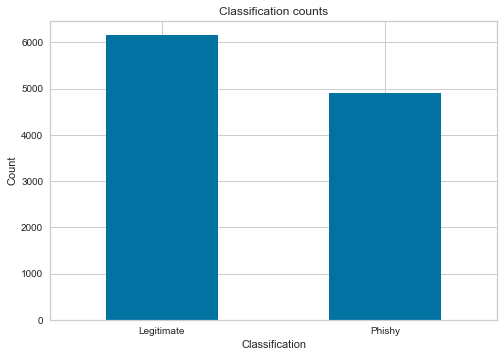

In [15]:
ax = df['Result'].value_counts().plot(kind="bar")
ax.set_xticklabels(["Legitimate", "Phishy"], rotation=0)
ax.set_xlabel("Classification")
ax.set_ylabel("Count")
ax.set_title("Classification counts")

In [5]:
df.drop(['index', 'Result'], axis=1).apply(pd.value_counts).fillna(0).astype(int)

,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report
-1,3793,8960,1444,1655,1429,9590,3363,3557,7389,2053,1502,1796,4495,3282,3956,8440,2014,1629,0,1315,476,2137,1012,5189,3443,2655,8201,1539,548,1550
0,0,135,0,0,0,0,3622,1167,0,0,0,0,0,5337,4449,761,0,0,9776,0,0,0,0,0,0,2569,0,0,6156,0
1,7262,1960,9611,9400,9626,1465,4070,6331,3666,9002,9553,9259,6560,2436,2650,1854,9041,9426,1279,9740,10579,8918,10043,5866,7612,5831,2854,9516,4351,9505


# Using only features specific to email analysis:

In [16]:
# Load classification dataset
# Drop index, Result, and features that are not directly important to email analysis
X = df.drop(columns=['index','Result', 'SSLfinal_State', 'Domain_registeration_length', 'Favicon', 'port', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report'])
y = df[['Result']]

X.shape

(11055, 9)

### Recursive Feature Elimination

We will use recursive feature elimination (RFE) to find the important features.

Recursive feature elimination is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. Features are ranked by the model’s coef_ or feature_importances_ attributes, and by recursively eliminating a small number of features per loop, RFE attempts to eliminate dependencies and collinearity that may exist in the model.

RFE requires a specified number of features to keep, however it is often not known in advance how many features are valid. To find the optimal number of features cross-validation is used with RFE to score different feature subsets and select the best scoring collection of features. The RFECV visualizer plots the number of features in the model along with their cross-validated test score and variability and visualizes the selected number of features.

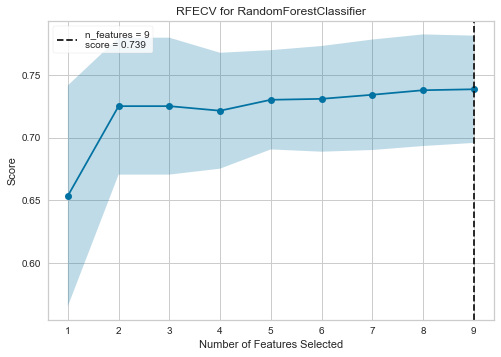

In [17]:
cv = StratifiedKFold(10, random_state=42)
visualizer = RFECV(RandomForestClassifier(random_state=42), cv=cv, scoring='f1_weighted')

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

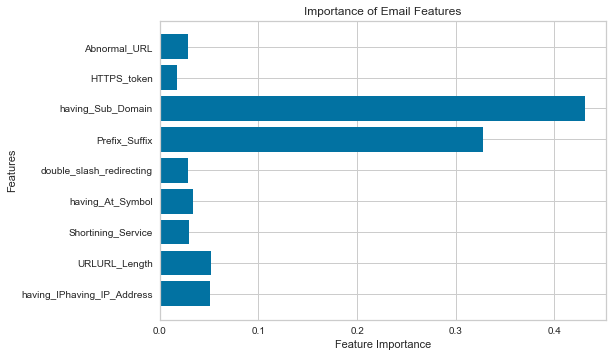

In [32]:
# Get the coefficients for feature importance, for each feature
feat_importances = visualizer.rfe_estimator_.estimator_.feature_importances_
feat_columns = X.columns[visualizer.support_]

# Use all features for the bar plot
y_pos = np.arange(len(feat_importances))

# Create bars
ax = plt.barh(y_pos, feat_importances, tick_label=feat_columns)

# Add title and axis names
plt.title('Importance of Email Features')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.savefig('email_feat_only.png', dpi=300, bbox_inches='tight')

# We can see that there are 2 features that are prominent 
# and appear to be the most important.

In [33]:
# Display the top features and their importance
pd.DataFrame(feat_importances,
             index = feat_columns,
             columns=['importance']).sort_values('importance', ascending=False)


,importance
having_Sub_Domain,0.430904
Prefix_Suffix,0.327949
URLURL_Length,0.051535
having_IPhaving_IP_Address,0.051028
having_At_Symbol,0.034060
Shortining_Service,0.029805
double_slash_redirecting,0.028943
Abnormal_URL,0.028078
HTTPS_token,0.017696


In [34]:
# Top-n features to select
top_n_feat = 3
top_n_feat_idx = sorted(range(len(feat_importances)), key=lambda i: feat_importances[i], reverse=True)[:top_n_feat]

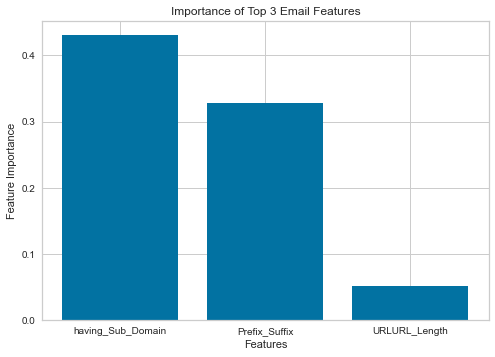

In [35]:
# Use only the top_n_features for the bar plot
bars = feat_columns[top_n_feat_idx]
y_pos = np.arange(len(feat_importances[top_n_feat_idx]))

# Create bars
plt.bar(y_pos, feat_importances[top_n_feat_idx])

# Create names on the x-axis
plt.xticks(y_pos, bars)

# Add title and axis names
plt.title('Importance of Top 3 Email Features')
plt.xlabel('Features')
plt.ylabel('Feature Importance')

plt.savefig('top_n_email_feat.png', dpi=300, bbox_inches='tight')

In [36]:
# Display the top n features and their importance
pd.DataFrame(feat_importances[top_n_feat_idx],
             index = feat_columns[top_n_feat_idx],
             columns=['importance']).sort_values('importance', ascending=False)

# We can see that 'having_Sub_Domain', 'Prefix_Suffix', and 'URLURL_Length' appear to be the more important features
# of the dataset that contains only columns that could specifically
# be used directly for email analysis.

,importance
having_Sub_Domain,0.430904
Prefix_Suffix,0.327949
URLURL_Length,0.051535


##  Sub Domain and Multi Sub Domains (having_Sub_Domain):

Let us assume we have the following link: http://www.hud.ac.uk/students/. A domain name might include the country-code top-level domains (ccTLD), which in our example is “uk”. The “ac” part is shorthand for “academic”, the combined “ac.uk” is called a second-level domain (SLD) and “hud” is the actual name of the domain. To produce a rule for extracting this feature, we firstly have to omit the (www.) from the URL which is in fact a sub domain in itself. Then, we have to remove the (ccTLD) if it exists. Finally, we count the remaining dots. If the number of dots is greater than one, then the URLis classified as “Suspicious” since it has one sub domain. However, if the dots are greater than two, it is classified as “Phishing” since it will have multiple sub domains. Otherwise, if the URL has no subdomains, we will assign “Legitimate” to the feature.

## Adding Prefix or Suffix Separated by (-) to the Domain (Prefix_Suffix):

The dash symbol is rarely used in legitimate URLs. Phishers tend to add prefixes or suffixes separatedby (-) to the domain name so that users feel that they are dealing with a legitimate webpage. For example http://www.Confirme-paypal.com/

## Long URL to Hide the Suspicious Part (URLURL_Length):

Phishers can use long URL to hide the doubtful part in the address bar. For example: http://federmacedoadv.com.br/3f/aze/ab51e2e319e51502f416dbe46b773a5e/?cmd=_home&amp;dispatch=11004d58f5b74f8dc1e7c2e8dd4105e811004d58f5b74f8dc1e7c2e8dd4105e8@phishing.website.html. To ensure accuracy of our study, we calculated the length of URLs in the dataset and produced anaverage URL length. The results showed that if the length of the URL is greater than or equal 54 characters then the URL classified as phishing. By reviewing our dataset we were able to find 1220 URLs lengths equals to 54 or more which constitute 48.8% of the total dataset size.

# Using All Features: 

In [37]:
# Load classification dataset
# Drop index, Result, and features that are not directly important to email analysis
X_all = df.drop(columns=['index','Result'])
y_all = df[['Result']]

X_all.shape

(11055, 30)

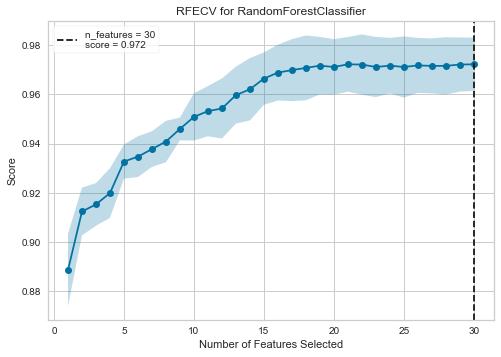

In [38]:
cv_all = StratifiedKFold(10, random_state=42)
visualizer_all = RFECV(RandomForestClassifier(random_state=42), cv=cv_all, scoring='f1_weighted')

visualizer_all.fit(X_all, y_all)        # Fit the data to the visualizer
visualizer_all.show()           # Finalize and render the figure

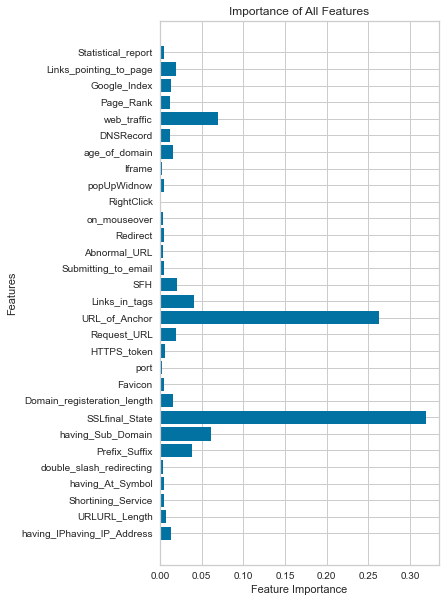

In [53]:
# Get the coefficients for feature importance, for each feature
feat_importances_all = visualizer_all.rfe_estimator_.estimator_.feature_importances_
feat_columns_all = X_all.columns[visualizer_all.support_]

# Use all important features for the bar plot
y_pos_all = np.arange(len(feat_importances_all))

# Create bars
plt.figure(figsize=(5,10))
plt.barh(y_pos_all, feat_importances_all, tick_label=feat_columns_all)

# Add title and axis names
plt.title('Importance of All Features')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.savefig('all_feat.png', dpi=300, bbox_inches='tight')

# We can see that there are 2 features that are very prominent and a few that are slightly prominent
# and appear to make up the more important features

In [16]:
# Display the top features and their importance
pd.DataFrame(feat_importances_all,
             index = feat_columns_all,
             columns=['importance']).sort_values('importance', ascending=False)

,importance
SSLfinal_State,0.318529
URL_of_Anchor,0.262463
web_traffic,0.070082
having_Sub_Domain,0.060848
Links_in_tags,0.041492
Prefix_Suffix,0.038782
SFH,0.020772
Request_URL,0.019452
Links_pointing_to_page,0.019059
Domain_registeration_length,0.016344


In [17]:
# Top-n features to select
top_n_feat_all = 3

top_n_feat_all_idx = sorted(range(len(feat_importances_all)), key=lambda i: feat_importances_all[i], reverse=True)[:top_n_feat_all]


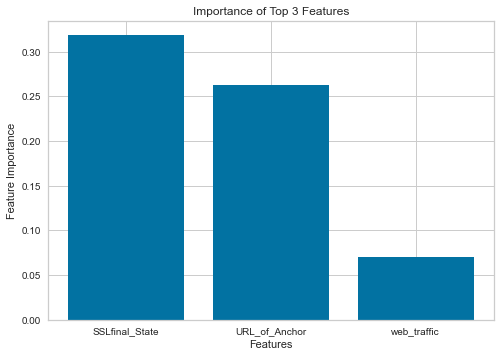

In [27]:
# Use only the top_n_features for the bar plot
bars_all = feat_columns_all[top_n_feat_all_idx]
y_pos_all = np.arange(len(feat_importances_all[top_n_feat_all_idx]))

# Create bars
plt.bar(y_pos_all, feat_importances_all[top_n_feat_all_idx])

# Create names on the x-axis
plt.xticks(y_pos_all, bars_all)

# Add title and axis names
plt.title('Importance of Top 3 Features')
plt.xlabel('Features')
plt.ylabel('Feature Importance')

plt.savefig('top_n_feat.png', dpi=300, bbox_inches='tight')

In [19]:
# Display the top n features and their importance
pd.DataFrame(feat_importances_all[top_n_feat_all_idx],
             index = feat_columns_all[top_n_feat_all_idx],
             columns=['importance']).sort_values('importance', ascending=False)

# We can see that 'SSLfinal_State', 'URL_of_Anchor', and 'web_traffic' appear to be the more important features
# of the full dataset.

,importance
SSLfinal_State,0.318529
URL_of_Anchor,0.262463
web_traffic,0.070082


## HTTPS (Hyper Text Transfer Protocol with Secure Sockets Layer) (SSLfinal_State):

The existence of HTTPS is very important in giving the impression of website legitimacy, but this is clearly not enough. The authors in [ CITATION Ram12 \l 1033 ][ CITATION Moh \l 1033 ] suggest checking the certificate assigned with HTTPS including the extent of the trust certificate issuer, and the certificate age. Certificate Authorities that are consistently listed among the top trustworthy names include: “GeoTrust, GoDaddy, Network Solutions, Thawte, Comodo, Doster and VeriSign”. Furthermore, by testing out our datasets, we find that the minimum age of a reputable certificate is two years.

## URL of Anchor:

An anchor is an element defined by the `<a>` tag. This feature examines:
    1. If the <a> tags and the website have different domain
       names. 
    2. If the anchor does not link to any webpage, e.g.:
        A. <a href=“#”>
        B. <a href=“#content”>
        C. <a href=“#skip”>
        D. <a href=“JavaScript ::void(0)”>

## Website Traffic:

This feature measures the popularity of the website by determining the number of visitors and the number of pages they visit. However, since phishing websites live for a short period of time, they may
not be recognized by the Alexa database. By reviewing our dataset, we find that in worst case scenarios, legitimate websites ranked among the top 100,000. Furthermore, if the domain has no traffic or is not recognized by the Alexa database, it is classified as “Phishing”. Otherwise, it is classified as “Suspicious”.